# EfficientNet
- The architecture of EfficientNet is based on a concept called "compound scaling." It means that the model is scaled up or down in a balanced way across different dimensions, such as depth, width, and resolution. This scaling ensures that the model is efficient in terms of both accuracy and resource utilization.

- Depth of the model refers to the number of layers. EfficientNet increases the depth by stacking more layers, allowing the model to learn complex patterns and features from the input images.

- Width refers to the number of channels in each layer. EfficientNet increases the width by expanding the number of channels, which helps the model capture more diverse information and make better predictions.

- Resolution is the size of the input images. EfficientNet adjusts the resolution based on a predefined scaling factor, which allows the model to handle images of different sizes efficiently.

## Abstract
Systematic balancing of model scaling that includes:
- Network depth: No. of Layers
- Network width: No. of Channels
- Resolution: Input Image shape

## Compound Scaling Method
Here,
- depth: d = alpha^phi
- width: w = beta^phi
- resolution: r = gamma^phi

And, increase in **phi**, increases the computational resource consumption by **2^phi**.

1. EfficientNet B0
- `Fix phi=1`, suct that `alpha x beta^2 x gamma^2 = 2`,so **alpha=1.2, beta=1.1 and gamma=1.15.**

2. EfficientNet B1 to EfficientNet B7
- `Fix alpha, beta and gamma` and scale baseline with `different phi`.


# EfficientNet Architecture

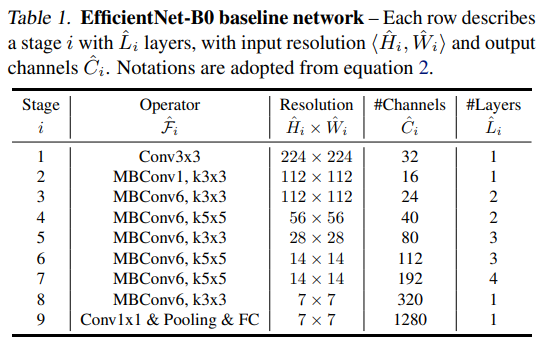

In [1]:
# Imports
import torch
import torch.nn as nn
from math import ceil

In [2]:
# Specifying base model for MBConv
base_model = [
    # Expand_ratio, channels, repeats, stride, kernel_size
    [1,16,1,1,3],
    [6,24,2,2,3],
    [6,40,2,2,5],
    [6,80,3,2,3],
    [6,112,3,1,5],
    [6,192,4,2,5],
    [6,320,1,1,3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0":(0, 224, 0.2),
    "b1":(0.5, 240, 0.2),
    "b2":(1, 260, 0.3),
    "b3":(2, 300, 0.3),
    "b4":(3, 380, 0.4),
    "b5":(4, 456, 0.4),
    "b6":(5, 528, 0.5),
    "b7":(6, 600, 0.5),
}

In [3]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
    super(CNNBlock, self).__init__()

    self.cnn = nn.Conv2d(in_channels,
                         out_channels,
                         kernel_size,
                         stride,
                         padding,
                         groups=groups, # 'groups' parameter for depth-wise convolution i.e for each channel independently
                         bias=False)

    self.bn = nn.BatchNorm2d(out_channels)
    self.silu = nn.SiLU()

  def forward(self, x):
    return self.silu(self.bn(self.cnn(x)))

**Note:** `groups` controls the connections between inputs and outputs. `in_channels` and `out_channels` must both be divisible by groups. For example,

- At groups=1, all inputs are convolved to all outputs.

- At groups=2, the operation becomes equivalent to having two conv layers side by side, each seeing half the input channels and producing half the output channels, and both subsequently concatenated.

- At groups= in_channels, each input channel is convolved with its own set of filters

In [4]:
class SqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduced_dim):
    super(SqueezeExcitation, self).__init__()

    self.se = nn.Sequential(nn.AdaptiveAvgPool2d(1), # CxHxW --> Cx1x1
                            nn.Conv2d(in_channels, reduced_dim, kernel_size=1), # Reduce the channels
                            nn.SiLU(),
                            nn.Conv2d(reduced_dim, in_channels, kernel_size=1), # Brings back the original channels
                            nn.Sigmoid()) # So that for each channel, value range between 0 and 1 i.e attention scores

  def forward(self, x):
    return x * self.se(x) # Each channel is multiplied to the value/attention scores which determines the priority

In [5]:
class InvertedResidualBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels,
               kernel_size,
               stride,
               padding,
               expand_ratio, # Expands i/p to higher number of channels --> depth-wise conv --> back to same shape of i/p
               reduction=4,# For squeeze excitation
               survival_prob=0.8 # For stochastic depth
               ):
    super(InvertedResidualBlock, self).__init__()

    self.survival_prob = 0.8
    self.use_residual = in_channels == out_channels and stride == 1 # Use residual connection if condition satisfies

    hidden_dim = in_channels * expand_ratio
    self.expand = in_channels != hidden_dim # In same stage -- no expansion , when switching stages -- expansion

    reduced_dim = int(in_channels / reduction)

    if self.expand:
      self.expand_conv = CNNBlock(
          in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
      )

    self.conv = nn.Sequential(
        CNNBlock(
            hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
        ),
        SqueezeExcitation(hidden_dim, reduced_dim),
        nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels))

  # For stochastic depth
  def stochastic_depth(self, x):
    if not self.training:
      return x

    # Compute binary tensor that'll be either 0 or 1
    binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
    return torch.div(x, self.survival_prob) * binary_tensor

  def forward(self, inputs):
    x = self.expand_conv(inputs) if self.expand else inputs

    if self.use_residual:
      return self.stochastic_depth(self.conv(x)) + inputs
    else:
      return self.conv(x)

In [6]:
class EfficientNet(nn.Module):
  def __init__(self, version, num_classes):
    super(EfficientNet, self).__init__()

    width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
    last_channels = ceil(1280 * width_factor)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.features = self.create_features(width_factor, depth_factor, last_channels)
    self.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(last_channels, num_classes),
    )

  def calculate_factors(self, version, alpha=1.2, beta=1.1):
    phi, resolution, drop_rate = phi_values[version]
    depth_factor = alpha ** phi
    width_factor = beta ** phi
    return width_factor, depth_factor, drop_rate

  def create_features(self, width_factor, depth_factor, last_channels):
    channels = int(32 * width_factor) # From initial conv layer, there are 32 channels which increases between stages
    features = [CNNBlock(3, channels, 3, stride=2, padding=1)] # Since image has in_channels = 3
    in_channels = channels # Update in_channels for next layer

    # Now iterate through all stages of base model
    for expand_ratio, channels, repeats, stride, kernel_size in base_model:

      # Since during Squeeze Excitation, we reduce the channels by 4, so making sure the out_channels is divisible by 4
      out_channels = 4 * ceil(int(channels * width_factor) / 4)

      layers_repeats = ceil(repeats * depth_factor)

      for layer in range(layers_repeats):
        features.append(
            InvertedResidualBlock(
                in_channels,
                out_channels,
                expand_ratio = expand_ratio,
                stride = stride if layer == 0 else 1,
                kernel_size = kernel_size,
                padding = kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
            )
        )
        in_channels = out_channels

    features.append(
        CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
    )

    return nn.Sequential(*features)

  def forward(self, x):
    x = self.pool(self.features(x))
    return self.classifier(x.view(x.shape[0], -1))


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
version = 'b2'

phi, resolution, drop_rate = phi_values[version]
num_images, num_classes = 4, 10

# Fake image for test --> so random generation
x = torch.randn((num_images, 3, resolution, resolution)).to(device)

# Instantiate the model
model = EfficientNet(
    version = version,
    num_classes=num_classes,
).to(device)

# Test
model(x).shape

torch.Size([4, 10])

In [8]:
# Generate the summary of the model
from torchsummary import summary

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 35, 112, 112]             945
       BatchNorm2d-2         [-1, 35, 112, 112]              70
              SiLU-3         [-1, 35, 112, 112]               0
          CNNBlock-4         [-1, 35, 112, 112]               0
            Conv2d-5         [-1, 35, 112, 112]             315
       BatchNorm2d-6         [-1, 35, 112, 112]              70
              SiLU-7         [-1, 35, 112, 112]               0
          CNNBlock-8         [-1, 35, 112, 112]               0
 AdaptiveAvgPool2d-9             [-1, 35, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             288
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 35, 1, 1]             315
          Sigmoid-13             [-1, 35, 1, 1]               0
SqueezeExcitation-14         [-1, 35, 1

# Load CIFAR-10 dataset

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to apply to the CIFAR-10 data
transform = transforms.Compose([transforms.Resize((224,224)), #<-- Resize for EfficientNet input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load train and test data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 29346759.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [11]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
# The classes in the dataset
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([3, 224, 224]) 0
Label:  airplane (0)


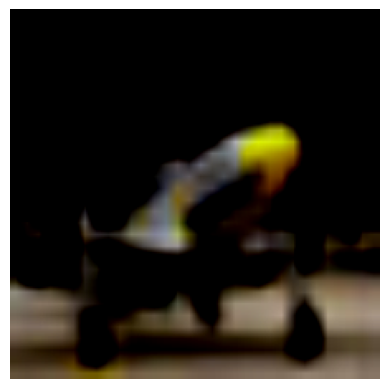

In [13]:
# Let's visualize the 12345th image in the train_dataset
feature, label = train_dataset[12344]
print(feature.shape, label)

import matplotlib.pyplot as plt

# Permute the image tensor from 3x224x224 to 224x224x3
image = torch.permute(feature, (1, 2, 0))

# Display the image
plt.imshow(image)
print('Label: ', train_dataset.classes[label], "("+str(label)+")")
plt.axis('off') # To remove axis label
plt.show()

# DataLoader for Train-Test Dataset

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
# Example from train_loader
train_iterate = iter(train_loader)
features, labels = next(train_iterate)
features.shape

torch.Size([64, 3, 224, 224])

In [16]:
labels

tensor([9, 3, 1, 9, 6, 0, 2, 0, 0, 0, 0, 5, 4, 6, 0, 9, 2, 5, 9, 4, 5, 8, 8, 8,
        2, 6, 5, 5, 8, 8, 8, 2, 3, 1, 0, 4, 2, 8, 3, 3, 6, 3, 9, 3, 0, 1, 2, 0,
        1, 4, 0, 8, 1, 7, 9, 5, 7, 0, 1, 3, 5, 7, 5, 8])

# Create Overfit Data
The dataset contains only 2 images of 5 classes -- 10 images in total

In [17]:
# New list to store final dataset
custom_dataset = [train_dataset[1], train_dataset[3], train_dataset[4], train_dataset[5], train_dataset[6], train_dataset[13], train_dataset[14], train_dataset[20], train_dataset[29], train_dataset[30]]


In [18]:
len(custom_dataset)

10

In [19]:
# Extracting image and label of 10th image
feature_custom, label_custom = custom_dataset[9]

In [20]:
feature_custom, label_custom

(tensor([[[-0.0118, -0.0118, -0.0118,  ..., -0.0824, -0.0824, -0.0824],
          [-0.0118, -0.0118, -0.0118,  ..., -0.0824, -0.0824, -0.0824],
          [-0.0118, -0.0118, -0.0118,  ..., -0.0824, -0.0824, -0.0824],
          ...,
          [-0.0353, -0.0353, -0.0353,  ..., -0.0510, -0.0510, -0.0510],
          [-0.0353, -0.0353, -0.0353,  ..., -0.0510, -0.0510, -0.0510],
          [-0.0353, -0.0353, -0.0353,  ..., -0.0510, -0.0510, -0.0510]],
 
         [[-0.0745, -0.0745, -0.0745,  ..., -0.1294, -0.1294, -0.1294],
          [-0.0745, -0.0745, -0.0745,  ..., -0.1294, -0.1294, -0.1294],
          [-0.0745, -0.0745, -0.0745,  ..., -0.1294, -0.1294, -0.1294],
          ...,
          [-0.0980, -0.0980, -0.0980,  ..., -0.1137, -0.1137, -0.1137],
          [-0.0980, -0.0980, -0.0980,  ..., -0.1137, -0.1137, -0.1137],
          [-0.0980, -0.0980, -0.0980,  ..., -0.1137, -0.1137, -0.1137]],
 
         [[-0.1373, -0.1373, -0.1373,  ..., -0.2235, -0.2235, -0.2235],
          [-0.1373, -0.1373,

Label:  airplane (0)


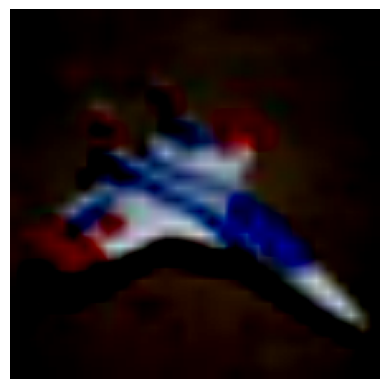

In [21]:
# Let's visualize the last image in the custom_dataset
import matplotlib.pyplot as plt

# Permute the image tensor from 3x224x224 to 224x224x3
image = torch.permute(feature_custom, (1, 2, 0))

# Display the image
plt.imshow(image)
print('Label: ', train_dataset.classes[label_custom], "("+str(label_custom)+")")
plt.axis('off') # To remove axis label
plt.show()

In [22]:
from torch.utils.data import Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

In [23]:
# Create an instance of the custom dataset
overfit = CustomDataset(custom_dataset)

In [24]:
# Len of overfit
len(overfit)

10

In [25]:
# Create DataLoader for overfit data
overfit_loader = torch.utils.data.DataLoader(overfit, batch_size=1, shuffle=True)

In [26]:
# Example checking the overfit_loader
of_iter = iter(overfit_loader)
of_feature, of_label = next(of_iter)
of_feature.shape

torch.Size([1, 3, 224, 224])

# Training and Validating with Overfit Data

In [27]:
# Instantiate the model
overfit_model = EfficientNet(
    version = 'b2', # For EfficientNet B2
    num_classes=10, # Need to test for 10 classes of CIFAR-10
).to(device)

In [28]:
# Compile tha model
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(overfit_model.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [29]:
from tqdm import tqdm
import time

history_loss = [] # To plot the epoch vs. loss
history_acc = [] # To plot the epoch vs. accuracy

for epoch in tqdm(range(100), desc='Epochs'):

  overfit_model.train()

  start_time = time.time() # Start time of the epoch

  running_loss = 0.0
  running_corrects = 0

  # Iterate over the training data in batches
  for inputs, labels in overfit_loader:
      # Move the inputs and labels to the selected device
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = overfit_model(inputs)
      torch.cuda.empty_cache() # Limit GPU memory growth

      # Calculate the loss
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      torch.cuda.empty_cache() # Limit GPU memory growth

      # Update running loss and accuracy
      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

  end_time = time.time()  # End time of the epoch
  epoch_duration = end_time - start_time  # Duration of the epoch

  # Calculate epoch loss and accuracy for training data
  epoch_loss = running_loss / len(overfit)
  epoch_acc = running_corrects.double() / len(overfit)

  history_loss.append(epoch_loss)
  history_acc.append(epoch_acc)

  if (epoch+1) % 10 == 0:
    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Print the loss and accuracy for overfit data
    print(f"Epoch [{epoch+1}/{100}], "
          f"Overfit Loss: {epoch_loss:.4f}, Overfit Accuracy: {epoch_acc:.4f}")

Epochs:  10%|█         | 10/100 [00:07<00:59,  1.50it/s]

Epoch 10 completed in 0.64 seconds
Epoch [10/100], Overfit Loss: 1.7102, Overfit Accuracy: 0.4000


Epochs:  20%|██        | 20/100 [00:15<01:06,  1.20it/s]

Epoch 20 completed in 1.23 seconds
Epoch [20/100], Overfit Loss: 1.6763, Overfit Accuracy: 0.2000


Epochs:  30%|███       | 30/100 [00:23<00:49,  1.41it/s]

Epoch 30 completed in 0.64 seconds
Epoch [30/100], Overfit Loss: 1.5700, Overfit Accuracy: 0.6000


Epochs:  40%|████      | 40/100 [00:30<00:41,  1.46it/s]

Epoch 40 completed in 0.64 seconds
Epoch [40/100], Overfit Loss: 1.2646, Overfit Accuracy: 1.0000


Epochs:  50%|█████     | 50/100 [00:36<00:32,  1.55it/s]

Epoch 50 completed in 0.65 seconds
Epoch [50/100], Overfit Loss: 0.9928, Overfit Accuracy: 1.0000


Epochs:  60%|██████    | 60/100 [00:44<00:28,  1.39it/s]

Epoch 60 completed in 0.76 seconds
Epoch [60/100], Overfit Loss: 0.7420, Overfit Accuracy: 1.0000


Epochs:  70%|███████   | 70/100 [00:51<00:20,  1.48it/s]

Epoch 70 completed in 0.72 seconds
Epoch [70/100], Overfit Loss: 0.6016, Overfit Accuracy: 1.0000


Epochs:  80%|████████  | 80/100 [00:57<00:12,  1.55it/s]

Epoch 80 completed in 0.64 seconds
Epoch [80/100], Overfit Loss: 0.5562, Overfit Accuracy: 1.0000


Epochs:  90%|█████████ | 90/100 [01:05<00:09,  1.02it/s]

Epoch 90 completed in 1.21 seconds
Epoch [90/100], Overfit Loss: 0.4796, Overfit Accuracy: 1.0000


Epochs: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]

Epoch 100 completed in 0.63 seconds
Epoch [100/100], Overfit Loss: 0.3864, Overfit Accuracy: 1.0000


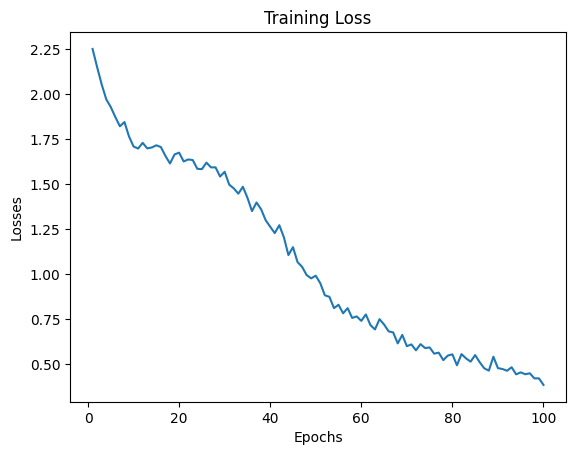

In [30]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_loss)+1)

# Plot losses
plt.plot(epochs, history_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()


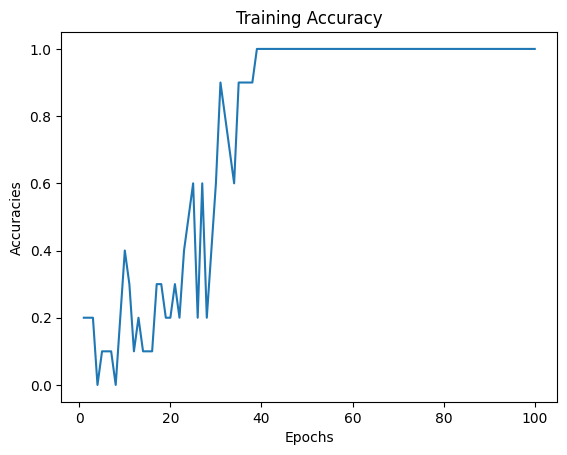

In [31]:
import numpy as np

# Plot epoch vs accuracy
history_acc = np.array([acc.cpu().numpy() for acc in history_acc])
plt.plot(epochs, history_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training Accuracy")
plt.show()

In [32]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    overfit_model.eval() # Set the model to evaluation mode

    for inputs, labels in overfit_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = overfit_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 10.00%


In [33]:
# Set the model to evaluation mode
model.eval()

# Iterate over the data loader
for images, labels in overfit_loader:

    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = overfit_model(images)
    _, predicted_indices = torch.topk(outputs, k=5, dim=1)

    # Print the true label and the top 5 predicted class indices
    print(f"True Label: {labels[0]}")
    print("Top 5 Predicted Class Indices:")
    for i, idx in enumerate(predicted_indices[0]):
        print(f"{i+1}. {idx.item()}")
    print("--------------------")

True Label: 1
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------
True Label: 4
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------
True Label: 0
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------
True Label: 1
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------
True Label: 0
Top 5 Predicted Class Indices:
1. 1
2. 0
3. 9
4. 4
5. 2
--------------------
True Label: 2
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------
True Label: 9
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------
True Label: 9
Top 5 Predicted Class Indices:
1. 1
2. 0
3. 4
4. 9
5. 2
--------------------
True Label: 2
Top 5 Predicted Class Indices:
1. 1
2. 0
3. 4
4. 9
5. 2
--------------------
True Label: 4
Top 5 Predicted Class Indices:
1. 0
2. 1
3. 4
4. 9
5. 2
--------------------


# Train on train dataset of CIFAR-10

In [34]:
# Instantiate the model
model_train = EfficientNet(
    version = 'b2', # For EfficientNet B2
    num_classes=10, # Need to test for 10 classes of CIFAR-10
).to(device)

In [35]:
# Compile the model
# Define the optimizer
optimizer = optim.Adam(model_train.parameters(), lr=0.0001) # Decrease the lr, because batch normalization

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [36]:
from tqdm import tqdm
import time

# Save train history
history_tl = []  # For epoch vs. loss
history_ta = [] # For epoch vs. accuracy

num_epochs = 5 # For less computation

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model_train.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Update running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1) # the maximum value and the index of that maximum value along dimension 1
        running_corrects += torch.sum(preds == labels.data) # labels.data gives access to underlying labels tensor

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Calculate epoch loss and accuracy for training data
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    history_tl.append(epoch_loss)
    history_ta.append(epoch_acc)

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

Epochs:  20%|██        | 1/5 [10:59<43:56, 659.22s/it]

Epoch 1 completed in 659.20 seconds
Epoch [1/5], Train Loss: 1.7604, Train Accuracy: 0.3432


Epochs:  40%|████      | 2/5 [21:56<32:53, 657.84s/it]

Epoch 2 completed in 656.86 seconds
Epoch [2/5], Train Loss: 1.2289, Train Accuracy: 0.5547


Epochs:  60%|██████    | 3/5 [32:52<21:54, 657.37s/it]

Epoch 3 completed in 656.80 seconds
Epoch [3/5], Train Loss: 0.9264, Train Accuracy: 0.6723


Epochs:  80%|████████  | 4/5 [43:49<10:57, 657.24s/it]

Epoch 4 completed in 657.04 seconds
Epoch [4/5], Train Loss: 0.7237, Train Accuracy: 0.7483


Epochs: 100%|██████████| 5/5 [54:50<00:00, 658.02s/it]

Epoch 5 completed in 660.12 seconds
Epoch [5/5], Train Loss: 0.5835, Train Accuracy: 0.7994


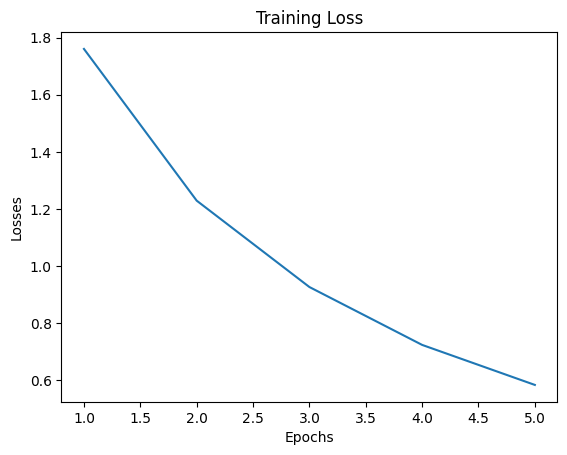

In [37]:
epochs = range(1, len(history_tl)+1)

# Plot losses
plt.plot(epochs, history_tl)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()


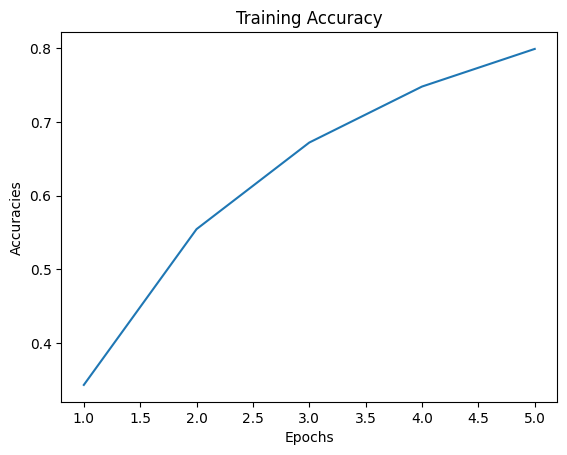

In [38]:
# Plot epoch vs accuracy
history_acc = np.array([acc.cpu().numpy() for acc in history_ta])
plt.plot(epochs, history_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training Accuracy")
plt.show()

# Testing on test dataset of CIFAR-10

In [39]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    model_train.eval() # Set the model to evaluation mode

    for inputs, labels in test_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 80.65%


In [40]:
# Visualize each image and predict its class on unseen dataset

def predict_image(img):
  # Convert to a batch of 1
  xb = img.unsqueeze(0).to(device)
  # Get predictions from model
  yb = model_train(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)

  return preds.item()

Actual Label:  ship (8)
Predicted Label:  ship (8)


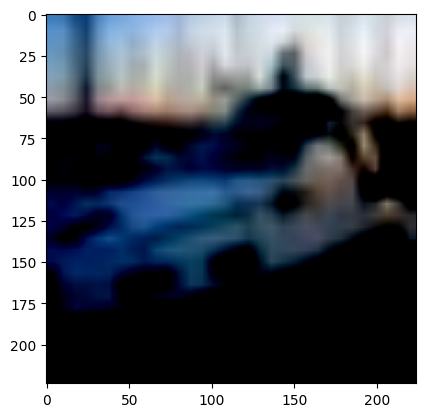

In [41]:
# For third image in dataset
img, label = test_dataset[2]
plt.imshow(img.permute(1,2,0))

predicted = predict_image(img)
print('Actual Label: ', test_dataset.classes[label], "("+str(label)+")")
print('Predicted Label: ', test_dataset.classes[predicted], "("+str(predicted)+")")

Actual Label:  deer (4)
Predicted Label:  deer (4)


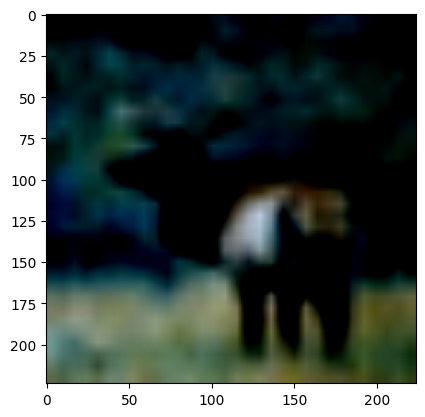

In [42]:
# For 1256th image in dataset
img, label = test_dataset[1255]
plt.imshow(img.permute(1,2,0))

predicted = predict_image(img)
print('Actual Label: ', test_dataset.classes[label], "("+str(label)+")")
print('Predicted Label: ', test_dataset.classes[predicted], "("+str(predicted)+")")